<a href="https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/4_callbacks_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Baselines3 Tutorial - Callbacks and hyperparameter tuning

Github repo: https://github.com/araffin/rl-tutorial-jnrr19/tree/sb3/

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines3.readthedocs.io/en/master/

SB3-Contrib: https://github.com/Stable-Baselines-Team/stable-baselines3-contrib

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo


## Introduction

In this notebook, you will learn how to use [Callbacks](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html) which allow to do monitoring, auto saving, model manipulation, progress bars, ...


You will also see that finding good hyperparameters is key to success in RL.

## Install Dependencies and Stable Baselines3 Using Pip

In [ ]:
# for autoformatting
# %load_ext jupyter_black

In [ ]:
!apt install swig
!pip install "stable-baselines3[extra]>=2.0.0a4"

In [1]:
import gymnasium as gym
from stable_baselines3 import A2C, SAC, PPO, TD3

# The importance of hyperparameter tuning

When compared with Supervised Learning, Deep Reinforcement Learning is far more sensitive to the choice of hyper-parameters such as learning rate, number of neurons, number of layers, optimizer ... etc. 
Poor choice of hyper-parameters can lead to poor/unstable convergence. This challenge is compounded by the variability in performance across random seeds (used to initialize the network weights and the environment).

Here we demonstrate on a toy example the [Soft Actor Critic](https://arxiv.org/abs/1801.01290) algorithm applied in the Pendulum environment. Note the change in performance between the default and "tuned" parameters. 

In [2]:
import numpy as np

from stable_baselines3.common.evaluation import evaluate_policy

In [3]:
eval_env = gym.make("Pendulum-v1")

In [4]:
default_model = SAC(
    "MlpPolicy",
    "Pendulum-v1",
    verbose=1,
    seed=0,
    batch_size=64,
    policy_kwargs=dict(net_arch=[64, 64]),
).learn(8000)

Using cpu device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.38e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 34        |
|    time_elapsed    | 23        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 18.7      |
|    critic_loss     | 1.46      |
|    ent_coef        | 0.811     |
|    ent_coef_loss   | -0.346    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.45e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 32        |
|    time_e

In [5]:
mean_reward, std_reward = evaluate_policy(default_model, eval_env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/home/ismail/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:-581.52 +/- 101.19


In [6]:
tuned_model = SAC(
    "MlpPolicy",
    "Pendulum-v1",
    batch_size=256,
    verbose=1,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=0,
).learn(8000)

Using cpu device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.37e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 23        |
|    time_elapsed    | 33        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 22.5      |
|    critic_loss     | 0.274     |
|    ent_coef        | 0.812     |
|    ent_coef_loss   | -0.341    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.39e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 21        |
|    time_e

In [7]:
mean_reward, std_reward = evaluate_policy(tuned_model, eval_env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-150.39 +/- 91.90


Exploring hyperparameter tuning is out of the scope (and time schedule) of this tutorial. However, you need to know that we provide tuned hyperparameter in the [rl zoo](https://github.com/DLR-RM/rl-baselines3-zoo) as well as automatic hyperparameter optimization using [Optuna](https://github.com/pfnet/optuna).


# Callbacks


Please read the [documentation](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html). Although Stable-Baselines3 provides you with a callback collection (e.g. for creating checkpoints or for evaluation), we are going to re-implement some so you can get a good understanding of how they work.

To build a custom callback, you need to create a class that derives from `BaseCallback`. This will give you access to events (`_on_training_start`, `_on_step()`) and useful variables (like `self.model` for the RL model).

`_on_step` returns a boolean value for whether or not the training should continue.

Thanks to the access to the models variables, in particular `self.model`, we are able to even change the parameters of the model without halting the training, or changing the model's code.

In [8]:
from stable_baselines3.common.callbacks import BaseCallback

In [9]:
class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseRLModel
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # type: logger.Logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: (bool) If the callback returns False, training is aborted early.
        """
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

Here we have a simple callback that can only be called twice:

In [10]:
class SimpleCallback(BaseCallback):
    """
    a simple callback that can only be called twice

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """

    def __init__(self, verbose=0):
        super(SimpleCallback, self).__init__(verbose)
        self._called = False

    def _on_step(self):
        if not self._called:
            print("callback - first call")
            self._called = True
            return True  # returns True, training continues.
        print("callback - second call")
        return False  # returns False, training stops.

In [11]:
model = SAC("MlpPolicy", "Pendulum-v1", verbose=1)
model.learn(8000, callback=SimpleCallback())

Using cpu device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
callback - first call
callback - second call


## First example: Auto saving best model
In RL, it is quite useful to keep a clean version of a model as you are training, as we can end up with burn-in of a bad policy. This is a typical use case for callback, as they can call the save function of the model, and observe the training over time.

Using the monitoring wrapper, we can save statistics of the environment, and use them to determine the mean training reward.
This allows us to save the best model while training.

Note that this is not the proper way of evaluating an RL agent, you should create an test environment and evaluate the agent performance in the callback (cf `EvalCallback`). For simplicity, we will be using the training reward as a proxy.

In [12]:
import os

import numpy as np

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [13]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq, log_dir, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print(
                        "Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(
                            self.best_mean_reward, mean_reward
                        )
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model at {} timesteps".format(x[-1]))
                        print("Saving new best model to {}.zip".format(self.save_path))
                    self.model.save(self.save_path)

        return True

In [14]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = make_vec_env("CartPole-v1", n_envs=1, monitor_dir=log_dir)
# it is equivalent to:
# env = gym.make('CartPole-v1')
# env = Monitor(env, log_dir)
# env = DummyVecEnv([lambda: env])

# Create Callback
callback = SaveOnBestTrainingRewardCallback(check_freq=20, log_dir=log_dir, verbose=1)

model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=5000, callback=callback)

Num timesteps: 100
Best mean reward: -inf - Last mean reward per episode: 90.00
Saving new best model at 90 timesteps
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 120
Best mean reward: 90.00 - Last mean reward per episode: 90.00
Num timesteps: 140
Best mean reward: 90.00 - Last mean reward per episode: 90.00
Num timesteps: 160
Best mean reward: 90.00 - Last mean reward per episode: 77.00
Num timesteps: 180
Best mean reward: 90.00 - Last mean reward per episode: 77.00
Num timesteps: 200
Best mean reward: 90.00 - Last mean reward per episode: 77.00
Num timesteps: 220
Best mean reward: 90.00 - Last mean reward per episode: 70.67
Num timesteps: 240
Best mean reward: 90.00 - Last mean reward per episode: 70.67
Num timesteps: 260
Best mean reward: 90.00 - Last mean reward per episode: 60.50
Num timesteps: 280
Best mean reward: 90.00 - Last mean reward per episode: 60.50
Num timesteps: 300
Best mean reward: 90.00 - Last mean reward per episode: 56.80
Num timesteps: 320
Best

Num timesteps: 2100
Best mean reward: 90.00 - Last mean reward per episode: 38.96
Num timesteps: 2120
Best mean reward: 90.00 - Last mean reward per episode: 39.15
Num timesteps: 2140
Best mean reward: 90.00 - Last mean reward per episode: 39.15
Num timesteps: 2160
Best mean reward: 90.00 - Last mean reward per episode: 39.11
Num timesteps: 2180
Best mean reward: 90.00 - Last mean reward per episode: 39.11
Num timesteps: 2200
Best mean reward: 90.00 - Last mean reward per episode: 39.27
Num timesteps: 2220
Best mean reward: 90.00 - Last mean reward per episode: 39.27
Num timesteps: 2240
Best mean reward: 90.00 - Last mean reward per episode: 39.26
Num timesteps: 2260
Best mean reward: 90.00 - Last mean reward per episode: 39.26
Num timesteps: 2280
Best mean reward: 90.00 - Last mean reward per episode: 39.12
Num timesteps: 2300
Best mean reward: 90.00 - Last mean reward per episode: 39.12
Num timesteps: 2320
Best mean reward: 90.00 - Last mean reward per episode: 39.00
Num timesteps: 2

Num timesteps: 4100
Best mean reward: 90.00 - Last mean reward per episode: 45.42
Num timesteps: 4120
Best mean reward: 90.00 - Last mean reward per episode: 45.42
Num timesteps: 4140
Best mean reward: 90.00 - Last mean reward per episode: 45.42
Num timesteps: 4160
Best mean reward: 90.00 - Last mean reward per episode: 45.42
Num timesteps: 4180
Best mean reward: 90.00 - Last mean reward per episode: 45.42
Num timesteps: 4200
Best mean reward: 90.00 - Last mean reward per episode: 45.42
Num timesteps: 4220
Best mean reward: 90.00 - Last mean reward per episode: 45.42
Num timesteps: 4240
Best mean reward: 90.00 - Last mean reward per episode: 46.91
Num timesteps: 4260
Best mean reward: 90.00 - Last mean reward per episode: 46.91
Num timesteps: 4280
Best mean reward: 90.00 - Last mean reward per episode: 46.91
Num timesteps: 4300
Best mean reward: 90.00 - Last mean reward per episode: 46.91
Num timesteps: 4320
Best mean reward: 90.00 - Last mean reward per episode: 46.91
Num timesteps: 4

## Second example: Realtime plotting of performance
While training, it is sometimes useful to how the training progresses over time, relative to the episodic reward.
For this, Stable-Baselines has [Tensorboard support](https://stable-baselines.readthedocs.io/en/master/guide/tensorboard.html), however this can be very combersome, especially in disk space usage. 

**NOTE: Unfortunately live plotting does not work out of the box on google colab**

Here, we can use callback again, to plot the episodic reward in realtime, using the monitoring wrapper:

<IPython.core.display.Javascript object>


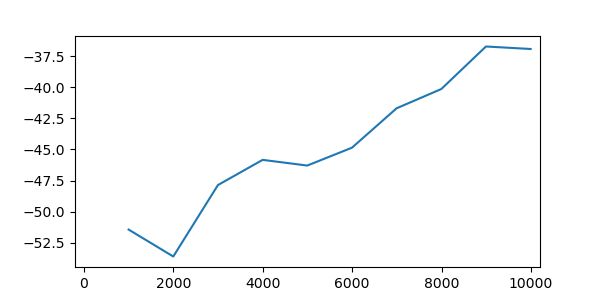

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook


class PlottingCallback(BaseCallback):
    """
    Callback for plotting the performance in realtime.

    :param verbose: (int)
    """
    def __init__(self, verbose=1):
        super().__init__(verbose)
        self._plot = None

    def _on_step(self) -> bool:
        # get the monitor's data
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if self._plot is None: # make the plot
            plt.ion()
            fig = plt.figure(figsize=(6,3))
            ax = fig.add_subplot(111)
            line, = ax.plot(x, y)
            self._plot = (line, ax, fig)
            plt.show()
        else: # update and rescale the plot
            self._plot[0].set_data(x, y)
            self._plot[-2].relim()
            self._plot[-2].set_xlim([self.locals["total_timesteps"] * -0.02, 
                                    self.locals["total_timesteps"] * 1.02])
            self._plot[-2].autoscale_view(True,True,True)
            self._plot[-1].canvas.draw()
        
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = make_vec_env('MountainCarContinuous-v0', n_envs=1, monitor_dir=log_dir)

plotting_callback = PlottingCallback()
        
model = PPO('MlpPolicy', env, verbose=0)
model.learn(10000, callback=plotting_callback)

## Third example: Progress bar
Quality of life improvement are always welcome when developping and using RL. Here, we used [tqdm](https://tqdm.github.io/) to show a progress bar of the training, along with number of timesteps per second and the estimated time remaining to the end of the training:

Please note that this callback is already included in SB3 and can be used by passing `progress_bar=True` to the `learn()` method.

In [16]:
from tqdm.auto import tqdm


class ProgressBarCallback(BaseCallback):
    """
    :param pbar: (tqdm.pbar) Progress bar object
    """

    def __init__(self, pbar):
        super().__init__()
        self._pbar = pbar

    def _on_step(self):
        # Update the progress bar:
        self._pbar.n = self.num_timesteps
        self._pbar.update(0)


# this callback uses the 'with' block, allowing for correct initialisation and destruction
class ProgressBarManager(object):
    def __init__(self, total_timesteps):  # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps

    def __enter__(self):  # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)

        return ProgressBarCallback(self.pbar)

    def __exit__(self, exc_type, exc_val, exc_tb):  # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()


model = TD3("MlpPolicy", "Pendulum-v1", verbose=0)
# Using a context manager garanties that the tqdm progress bar closes correctly
with ProgressBarManager(2000) as callback:
    model.learn(2000, callback=callback)

  0%|          | 0/2000 [00:00<?, ?it/s]

## Forth example: Composition
Thanks to the functional nature of callbacks, it is possible to do a composition of callbacks, into a single callback. This means we can auto save our best model, show the progress bar and episodic reward of the training.

The callbacks are automatically composed when you pass a list to the `learn()` method. Under the hood, a `CallbackList` is created.

In [17]:
from stable_baselines3.common.callbacks import CallbackList

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = make_vec_env('CartPole-v1', n_envs=1, monitor_dir=log_dir)

# Create callbacks
auto_save_callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

model = PPO('MlpPolicy', env, verbose=0)
with ProgressBarManager(1000) as progress_callback:
  # This is equivalent to callback=CallbackList([progress_callback, auto_save_callback])
  model.learn(1000, callback=[progress_callback, auto_save_callback])

  0%|          | 0/1000 [00:00<?, ?it/s]

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 22.66
Saving new best model at 997 timesteps
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 2000
Best mean reward: 22.66 - Last mean reward per episode: 22.32


## Exercise: Code your own callback


The previous examples showed the basics of what is a callback and what you do with it.

The goal of this exercise is to create a callback that will evaluate the model using a test environment and save it if this is the best known model.

To make things easier, we are going to use a class instead of a function with the magic method `__call__`.

In [18]:
class EvalCallback(BaseCallback):
    """
    Callback for evaluating an agent.

    :param eval_env: (gym.Env) The environment used for initialization
    :param n_eval_episodes: (int) The number of episodes to test the agent
    :param eval_freq: (int) Evaluate the agent every eval_freq call of the callback.
    """

    def __init__(self, eval_env, n_eval_episodes=5, eval_freq=20):
        super().__init__()
        self.eval_env = eval_env
        self.n_eval_episodes = n_eval_episodes
        self.eval_freq = eval_freq
        self.best_mean_reward = -np.inf

    def _on_step(self):
        """
        This method will be called by the model.

        :return: (bool)
        """

        # self.n_calls is automatically updated because
        # we derive from BaseCallback
        if self.n_calls % self.eval_freq == 0:
            # === YOUR CODE HERE ===#
            # Evaluate the agent:
            # you need to do self.n_eval_episodes loop using self.eval_env
            # hint: you can use self.model.predict(obs, deterministic=True)

            # Save the agent if needed
            # and update self.best_mean_reward

            print("Best mean reward: {:.2f}".format(self.best_mean_reward))

            # ====================== #
        return True

### Test your callback

In [20]:
# Env used for training
env = gym.make("CartPole-v1")
# Env for evaluating the agent
eval_env = gym.make("CartPole-v1")

# === YOUR CODE HERE ===#
# Create the callback object
callback = None

# Create the RL model
model = PPO('MlpPolicy', env, verbose=0)

# Train the RL model
model.learn(int(100000), callback=EvalCallback)

# Conclusion


In this notebook we have seen:
- that good hyperparameters are key to the success of RL, you should not except the default ones to work on every problems
- what is a callback and what you can do with it
- how to create your own callback
